## GAN to balance the training data-set
## This notebook is to apply WGAN on Scania Dataset with PCA (PCs=11), with different Imbalance Ratio

**Yasmin Fathy <Fathy.Yasmin@gmail.com>**

**Latest Updates: 30/08/2020**

In [1]:
import pandas as pd
import numpy as np
import os
from pprint import pprint

# to display fully (non-truncated) data-frame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#pd.set_option('display.max_colwidth', -1)

#Setup to show all results in jupiter not only the last one:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # revert to 'last_expr' to get only last results

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
from pprint import pprint

import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (20,20)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

## Evaluation

In [2]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, make_scorer,\
    recall_score, f1_score, precision_recall_curve, log_loss, cohen_kappa_score,roc_curve, auc
from tqdm import tqdm

In [3]:
RANDOM_STATE = 42

**APS Misclasification Cost Function**

In [4]:
def __perform_measure(y_actual, y_hat):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        y_actual = list(y_actual)
        y_hat = list(y_hat)
        for i in range(len(y_hat)):
            if y_actual[i] == y_hat[i] == 1:
                TP += 1
            if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
                FP += 1
            if y_actual[i] == y_hat[i] == 0:
                TN += 1
            if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
                FN += 1

        return [TP, FP, TN, FN]

def custom_cost_fn_loss(y_actual, y_hat):
        [TP, FP, TN, FN] = __perform_measure(y_actual, y_hat)
        # print(len(list(y_actual)),
        #       len(list(y_hat)))
        # cm = confusion_matrix(list(y_actual), list(y_hat))
        # print(len(cm))
        # print(len(cm[0]))
        # print(cm)
        # FP = cm[0][1]
        # FN = cm[1][0]
        return (500 * FN) + (FP * 10)
    
APS_cost_fn = make_scorer(custom_cost_fn_loss, greater_is_better=False)

### ML Model Evalution

- **y** : original label in the testing-set
- **y_predict**: predicted label from the ML algorithm
- **y_predict_prob**: probability output of the algorithm about the minority class

**Plotting the precision, recall curve**

In [5]:
def plot_precession_recall_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='Precision Recall curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Precision Recall curve  '+ str(alg_name))
    plt.legend(loc="lower right")
    plt.show();

In [6]:
def plot_roc_auc_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = roc_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

**Evaluating the results using a set of metrics**

In [7]:
def model_evaluaiton(y, y_predict, alg_name):        
            print(classification_report(y, list(y_predict)))
            cm = confusion_matrix(y, list(y_predict))
            print(cm)
            print("Accuracy:", accuracy_score(y, y_predict))
            print("roc_auc_score:", roc_auc_score(y, y_predict))
            print("precision_score:", precision_score(y, y_predict))
            print("recall_score:", recall_score(y, y_predict))
            print("f1_score:", f1_score(y, y_predict))
            FP = cm[0][1]
            FN = cm[1][0]
            print("CM: FP", FP)
            print("CM: FN", FN)
            print("APS Cost = ", (500 * FN) + (FP * 10))
            plot_precession_recall_curve(y, y_predict, alg_name)
            plot_roc_auc_curve(y, y_predict, alg_name)

**Finding the threshold that minimises the misclassification of the minority class i.e. class = 1 and apply the best threshold as post-processing steps**

In [8]:
def find_cut_off(y, y_predict_prob_maj):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict_prob_maj)
    min_cost = np.inf
    best_threshold = 0.5
    costs = []
    for threshold in tqdm(thresholds):
        #y_pred_threshold = np.where(scores > threshold, 0, 1)
        y_pred_threshold = y_predict_prob_maj > threshold
        tn, fp, fn, tp = confusion_matrix(y, y_pred_threshold).ravel()
        cost = 10*fp + 500*fn
        costs.append(cost)
        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold
    print("Best threshold: {:.4f}".format(best_threshold))
    print("Min cost: {:.2f}".format(min_cost))
    return best_threshold
    

---

## Read training and testing files

**Get the minority class samples**

In [9]:
def get_minority(df_train):
    return df_train[df_train['class'] == 1]

In [10]:
data_dir ="ScaniaDataset/dimReduction/"
df_train = pd.read_csv(data_dir+"pca_aps_mean_failure_train_set.csv")
df_test =  pd.read_csv(data_dir+"pca_aps_mean_failure_test_set.csv")

data_dir ="ScaniaDataset/"
df_gan = pd.read_csv(data_dir+"WGAN_Scania.csv")

df_orig_minority = get_minority(df_train)

# data_dir ="ScaniaDataset/imputation/"
# df_train = pd.read_csv(data_dir+"imp_aps_mean_failure_training_set.csv")
# df_test =  pd.read_csv(data_dir+"imp_aps_mean_failure_test_set.csv")

In [11]:
df_train[10:12]

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
10,0.138328,-0.330887,-0.156912,-0.012809,0.061510,-0.037770,-0.046260,0.00685,-0.024045,0.021380,-0.005061,0
11,0.023933,-0.149777,-0.167296,-0.038588,0.058541,-0.037378,0.065629,0.02009,0.042327,-0.035638,0.003502,0


In [12]:
df_train["class"].value_counts()

df_test["class"].value_counts()

0    59000
1     1000
Name: class, dtype: int64

0    15625
1      375
Name: class, dtype: int64

In [13]:
df_train.head()
df_test.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
0,-0.357653,0.149168,0.785559,0.107379,-0.068720,-0.028512,0.128307,0.002902,-0.073669,0.079233,-0.019663,0
1,-0.009868,0.178451,-0.153641,-0.106095,0.115751,0.677376,0.038713,0.021226,0.052543,-0.016909,-0.012898,0
2,0.036263,-0.202770,-0.164386,-0.072079,0.131766,-0.043973,-0.051563,-0.000143,0.000497,-0.034116,-0.000904,0
3,0.207965,-0.419020,-0.145090,-0.048601,-0.000098,-0.007554,-0.008067,0.004260,0.006622,0.011792,-0.001259,0
4,-0.111736,0.259781,-0.174570,-0.061653,-0.000418,-0.020208,0.079826,-0.010607,0.004089,-0.047178,-0.014056,0


,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
0,0.161155,-0.296518,-0.147703,-0.064035,-0.017811,-0.017302,0.001606,0.008635,0.022569,0.004805,-0.000669,0
1,0.197147,-0.390714,-0.145632,-0.052749,-0.003007,-0.008112,-0.006774,0.005026,0.008747,0.010879,-0.000986,0
2,-0.271152,0.611412,-0.183003,-0.143001,-0.002290,-0.010953,0.107131,-0.045472,0.038387,-0.092350,0.044199,0
3,-0.134755,0.120177,-0.180050,-0.094396,0.112898,-0.045628,0.058169,0.005929,0.011544,-0.038997,-0.004686,0
4,0.171726,-0.324381,-0.146679,-0.064361,-0.004982,-0.002021,-0.007429,0.004521,0.007393,0.011175,-0.000230,0


----

### Use data generated by GAN to preserve different ratio between the majoirty and minority classes

In [14]:
from collections import Counter
from numpy import log
from imblearn.over_sampling import SMOTE 

Using TensorFlow backend.


**Using the Shannon entropy as a measure of balance**
- Where IR tends to be:
    - 0 when the data is highly imbalanced and 
    - 1 when the data is balanced.

- Inspired from: 
https://stats.stackexchange.com/questions/239973/a-general-measure-of-data-set-imbalance


In [15]:
def imbalance_ratio(seq):
    n = len(seq)
    classes = [(label,float(count)) for 
               label,count in Counter(seq).items()]
    #print(classes)
    k = len(classes)
    #print(k)
    #calculate shannon entropy
    H = -sum([ (count/n) * log((count/n)) 
              for label,count in classes]) 
    #print(H)
    # get imbalance ratio
    IR = H/log(k)
    print("Non-normliased = ", str(H))
    print("IR = ", str(IR))
    return IR # near 0: high imbalance, near 1: high balance

**Check if we have the same value report for Normalised Shannon Entropy that is calculated in paper "A methodology..." isn't normalised**
- It turns out the shannon value in their paper isn't normalised, check the example on the original data
- Original data has the following counts for each class
[(0, 59000.0), (1, 1000.0)]

In [16]:
log((1/60)) 

-4.0943445622221

In [17]:
#[(0, 59000.0), (1, 1000.0)]
-((1/60) * log((1/60)) + ((59/60) * log((59/60))))
-((1/60) * log((1/60)) + ((59/60) * log((59/60))))/log(2)

0.08476607571480994

0.1222915970693747

**Measure IR for the original data**

In [18]:
imbalance_ratio(df_train["class"])

Non-normliased =  0.08476607571480994
IR =  0.1222915970693747


0.1222915970693747

**To reproduce Case II Experiements:**
- sampling_strategy = 2/59 => IR = 0.2
- sampling_strategy = 5/59 => IR = 0.4
- sampling_strategy = 9/59, 10/59, 11/59 => IR = 0.6
- sampling_strategy = 18/59 => IR = 0.8
- sampling_strategy = 59/59 => IR = 1.0

**define a dataframe for each case**

- IR =  0.1222915970693747 (original case we already have its results)

Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 2000 (3.278688524590164%)
After OverSampling, counts of label '0': 59000 (96.72131147540983%)



- IR =  0.20818094555717104

Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 5000 (7.8125%)
After OverSampling, counts of label '0': 59000 (92.1875%)


- IR =  0.3955378064564774


Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 10000 (14.492753623188406%)
After OverSampling, counts of label '0': 59000 (85.5072463768116%)




- IR =  0.596999516760455

Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 18000 (23.376623376623375%)
After OverSampling, counts of label '0': 59000 (76.62337662337663%)



- IR =  0.7845191388986642


Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 59000 (50.0%)
After OverSampling, counts of label '0': 59000 (50.0%)
IR =  1.0

In [19]:
#sample_strategies = [2, 5, 10, 18, 59]

In [20]:
x=imbalance_ratio(df_train['class'])

print("".join(["="]*20))
## create df for IR = 0.2
df_train_2 = pd.concat([df_train, df_gan[:1000]])
x=imbalance_ratio(df_train_2['class'])
c_0 = len(df_train_2[df_train_2["class"]==0])
c_1 = len(df_train_2[df_train_2["class"]==1])
print("After OverSampling, counts of label '0': {} ({}%)".format(c_0, (c_0/len(df_train_2))* 100))
print("After OverSampling, counts of label '1': {} ({}%)\n".format(c_1, (c_1/len(df_train_2))* 100))

print("".join(["="]*20))

## create df for IR = 0.4
df_train_5 = pd.concat([df_train, df_gan[1000:5000]])
x=imbalance_ratio(df_train_5['class'])
c_0 = len(df_train_5[df_train_5["class"]==0])
c_1 = len(df_train_5[df_train_5["class"]==1])
print("After OverSampling, counts of label '0': {} ({}%)".format(c_0, (c_0/len(df_train_5))* 100))
print("After OverSampling, counts of label '1': {} ({}%)\n".format(c_1, (c_1/len(df_train_5))* 100))
print("".join(["="]*20))

## create df for IR = 0.6
df_train_10 = pd.concat([df_train, df_gan[5000:14000]])
x=imbalance_ratio(df_train_10['class'])
c_0 = len(df_train_10[df_train_10["class"]==0])
c_1 = len(df_train_10[df_train_10["class"]==1])
print("After OverSampling, counts of label '0': {} ({}%)".format(c_0, (c_0/len(df_train_10))* 100))
print("After OverSampling, counts of label '1': {} ({}%)\n".format(c_1, (c_1/len(df_train_10))* 100))
print("".join(["="]*20))

# ## create df for IR = 0.8
# df_train_18 = pd.concat([df_train, df_gan[14000:31000]])
# x=imbalance_ratio(df_train_18['class'])
# c_0 = len(df_train_18[df_train_18["class"]==0])
# c_1 = len(df_train_18[df_train_18["class"]==1])
# print("After OverSampling, counts of label '0': {} ({}%)".format(c_0, (c_0/len(df_train_18))* 100))
# print("After OverSampling, counts of label '1': {} ({}%)\n".format(c_1, (c_1/len(df_train_18))* 100))
# print("".join(["="]*20))

# ## create df for IR = 1.0
# df_train_59 = pd.concat([df_train, df_gan])
# x=imbalance_ratio(df_train_59['class'])

Non-normliased =  0.08476607571480994
IR =  0.1222915970693747
Non-normliased =  0.14430003545925657
IR =  0.20818094555717104
After OverSampling, counts of label '0': 59000 (96.72131147540983%)
After OverSampling, counts of label '1': 2000 (3.278688524590164%)

Non-normliased =  0.27416591535017265
IR =  0.3955378064564774
After OverSampling, counts of label '0': 59000 (92.1875%)
After OverSampling, counts of label '1': 5000 (7.8125%)

Non-normliased =  0.41380853183815924
IR =  0.596999516760455
After OverSampling, counts of label '0': 59000 (85.5072463768116%)
After OverSampling, counts of label '1': 10000 (14.492753623188406%)



## Get difference between generated and original
**Note: SMOTE concatenates the newly generated samples to the end of the original input data and returns that as the output**
- ref: https://datascience.stackexchange.com/questions/12768/location-of-the-resampled-data-from-smote

In [21]:
# df_minroty: is the data samples of the minority class in the original data
# df_generated: is all data samples including synthetic generated minority class and original data samples

from scipy import stats
def get_ks_test(df_minroty, df_generated, return_generated_df = False):
    # get the generated samples from smote by getting the difference between original dataset in "df_train" and sampled dataset "df_generated"
    # (which contains/combines original and generated data)
    minority_generated = df_generated[~df_generated.apply(tuple,1).isin(df_train.apply(tuple,1))]
    no_cols = len(df_minroty.columns)-1
    for idx in range(0, no_cols):
        print(stats.ks_2samp(df_minroty.iloc[:,idx], 
                       minority_generated.iloc[:, idx]))
    if return_generated_df:
        return minority_generated
    

In [22]:
# minority_generated = df_train_5[~df_train_5.apply(tuple,1).isin(df_train.apply(tuple,1))]
# minority_generated = minority_generated.drop(['class'], axis=1)
# # minority_generated

# minority_original = df_minority.drop(['class'], axis=1)
# # minority_original

# minority_original.corrwith(minority_generated, axis=0)

In [23]:
# from scipy.stats import pearsonr
# corr, _ = pearsonr(minority_original, minority_generated)
# corr
# p = minority_generated.to_numpy()
# q = minority_original.to_numpy()

# BC=np.sum(np.sqrt(p*q))
# BC

In [24]:
get_ks_test(df_orig_minority, df_train_2)

Ks_2sampResult(statistic=0.84, pvalue=0.0)
Ks_2sampResult(statistic=0.652, pvalue=6.2952636855258486e-201)
Ks_2sampResult(statistic=0.934, pvalue=0.0)
Ks_2sampResult(statistic=0.868, pvalue=0.0)
Ks_2sampResult(statistic=0.482, pvalue=1.3758331243978358e-105)
Ks_2sampResult(statistic=0.408, pvalue=7.826453559784953e-75)
Ks_2sampResult(statistic=0.508, pvalue=7.758325610986461e-118)
Ks_2sampResult(statistic=0.408, pvalue=7.826453559784953e-75)
Ks_2sampResult(statistic=0.447, pvalue=2.6573756410355674e-90)
Ks_2sampResult(statistic=0.462, pvalue=1.094516839708168e-96)
Ks_2sampResult(statistic=0.428, pvalue=1.4539281678631267e-82)


In [25]:
get_ks_test(df_orig_minority, df_train_5)

Ks_2sampResult(statistic=0.83525, pvalue=0.0)
Ks_2sampResult(statistic=0.6595, pvalue=1.1846475032951622e-302)
Ks_2sampResult(statistic=0.9365, pvalue=0.0)
Ks_2sampResult(statistic=0.86825, pvalue=0.0)
Ks_2sampResult(statistic=0.47975, pvalue=2.3411963504753525e-160)
Ks_2sampResult(statistic=0.40325, pvalue=2.0306637070173512e-113)
Ks_2sampResult(statistic=0.509, pvalue=1.8754786737138766e-180)
Ks_2sampResult(statistic=0.4055, pvalue=1.1045607911472387e-114)
Ks_2sampResult(statistic=0.44325, pvalue=6.015893722864079e-137)
Ks_2sampResult(statistic=0.45875, pvalue=1.1595949437203707e-146)
Ks_2sampResult(statistic=0.424, pvalue=2.3981169010577563e-125)


In [26]:
get_ks_test(df_orig_minority, df_train_10)

Ks_2sampResult(statistic=0.8371111111111111, pvalue=0.0)
Ks_2sampResult(statistic=0.6582222222222223, pvalue=0.0)
Ks_2sampResult(statistic=0.9366666666666666, pvalue=0.0)
Ks_2sampResult(statistic=0.8675555555555555, pvalue=0.0)
Ks_2sampResult(statistic=0.479, pvalue=8.711673601081419e-180)
Ks_2sampResult(statistic=0.4053333333333333, pvalue=7.355322323303694e-129)
Ks_2sampResult(statistic=0.5096666666666667, pvalue=1.7327696088373458e-203)
Ks_2sampResult(statistic=0.4048888888888889, pvalue=1.4063769543935566e-128)
Ks_2sampResult(statistic=0.444, pvalue=1.5627568945762487e-154)
Ks_2sampResult(statistic=0.4603333333333333, pvalue=4.4374177418046757e-166)
Ks_2sampResult(statistic=0.42344444444444446, pvalue=1.3575812777836937e-140)


In [27]:
# get_ks_test(df_orig_minority, df_train_18)

In [28]:
# get_ks_test(df_orig_minority, df_train_59)

In [29]:
# df_2_generated = df_train_2[~df_train_2.apply(tuple,1).isin(df_train.apply(tuple,1))]
# len(df_2_generated)

**Prepare test dataset**

In [30]:
y_test = df_test['class']
X_test = df_test.drop(['class'], axis=1)

In [31]:
len(X_test)

16000

----

## ML Predictive models on the data with augmentation minotity samples generated from GAN
**LR, RF, XGBoost are trained and tested for each case mentioned above**

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


In [33]:
#scoring_fn = "f1_weighted"
scoring_fn = APS_cost_fn

**Prepare training dataset**

In [34]:
def get_train_data(df_t):
    y_train = df_t['class']
    X_train = df_t.drop(['class'], axis=1)
    return X_train, y_train
    

**Make prediction of best model given X_test**

In [35]:
def model_prediction(best_model, X_test):
    print("Best estimator: ", best_model.best_estimator_)
    # X = X.values.reshape(-1, 1)
    model_prediction = best_model.predict(X_test)
    model_prob_prediction = best_model.predict_proba(X_test) 
    return model_prediction, model_prob_prediction

### Logistic Regression: 

In [36]:
# y_train = df_train['class']
# X_train = df_train.drop(['class'], axis=1)

In [37]:
def lr_model(X_train, y_train):
    LR_hyperparameters = dict(C=[0.01, 1, 10, 100],
                             max_iter=[6000])  # hyperparameter options

#     # # Best options obtained from running the params mentioned above
#     LR_hyperparameters = dict(C=[1], max_iter=[6000])  # hyperparameter options
    LR_clf = GridSearchCV(LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE),
                               param_grid=LR_hyperparameters, cv=5,
                               verbose=2, scoring=scoring_fn, n_jobs=-1)

    LR_best_model = LR_clf.fit(X_train, y_train)
    return LR_best_model

### df_train_2 (i.e. IR = 0.2)

In [38]:
X_train_2, y_train_2 = get_train_data(df_train_2)
LR_best_model_2 = lr_model(X_train_2, y_train_2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.4s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.24      0.97      0.38       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.67     16000
weighted avg       0.98      0.93      0.95     16000

[[14467  1158]
 [   10   365]]
Accuracy: 0.927
roc_auc_score: 0.9496106666666667
precision_score: 0.2396585686145765
recall_score: 0.9733333333333334
f1_score: 0.38461538461538464
CM: FP 1158
CM: FN 10
APS Cost =  16580


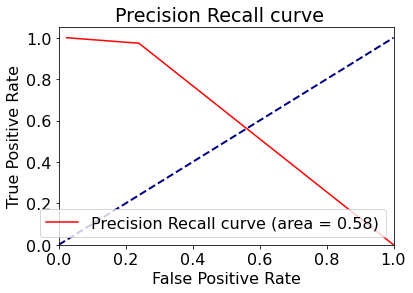

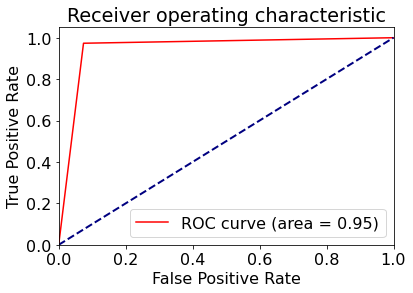

In [39]:
LR_model_pred_test_2, LR_model_prob_pred_test_2 = model_prediction(LR_best_model_2, X_test)
model_evaluaiton(y_test, LR_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.96     59000
         1.0       0.26      0.79      0.39      2000

    accuracy                           0.92     61000
   macro avg       0.62      0.86      0.67     61000
weighted avg       0.97      0.92      0.94     61000

[[54396  4604]
 [  419  1581]]
Accuracy: 0.917655737704918
roc_auc_score: 0.8562330508474576
precision_score: 0.25561843168957155
recall_score: 0.7905
f1_score: 0.3863164324984728
CM: FP 4604
CM: FN 419
APS Cost =  255540


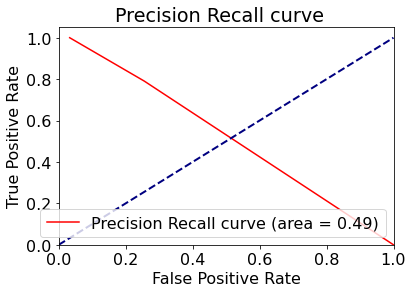

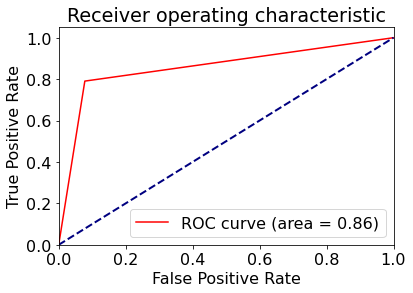

In [40]:
LR_model_pred_train_2, LR_model_prob_pred_train_2 = model_prediction(LR_best_model_2, X_train_2)
model_evaluaiton(y_train_2, LR_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [41]:
LR_best_th_2 = find_cut_off(y_test, LR_model_prob_pred_test_2[:,1])

100%|██████████| 13415/13415 [15:30<00:00, 14.42it/s]

Best threshold: 0.5277
Min cost: 15880.00


In [42]:
LR_best_th_2

0.5277437400288801

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.97      0.40       375

    accuracy                           0.93     16000
   macro avg       0.63      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14537  1088]
 [   10   365]]
Accuracy: 0.931375
roc_auc_score: 0.9518506666666667
precision_score: 0.25120440467997246
recall_score: 0.9733333333333334
f1_score: 0.3993435448577681
CM: FP 1088
CM: FN 10
APS Cost =  15880


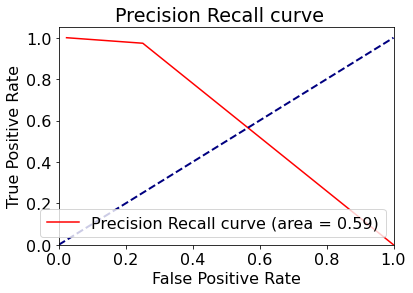

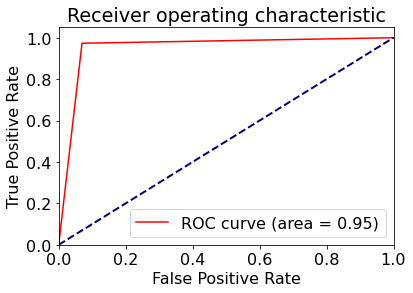

In [43]:
LR_predict_test_th_2 = LR_model_prob_pred_test_2[:,1] > LR_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [44]:
(1.0-LR_best_th_2)
lr_th_2 = round((1.0-LR_best_th_2),3)
lr_th_2

0.47225625997111986

0.472

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.97      0.40       375

    accuracy                           0.93     16000
   macro avg       0.63      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14537  1088]
 [   10   365]]
Accuracy: 0.931375
roc_auc_score: 0.9518506666666667
precision_score: 0.25120440467997246
recall_score: 0.9733333333333334
f1_score: 0.3993435448577681
CM: FP 1088
CM: FN 10
APS Cost =  15880


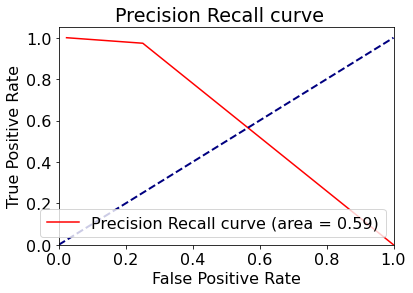

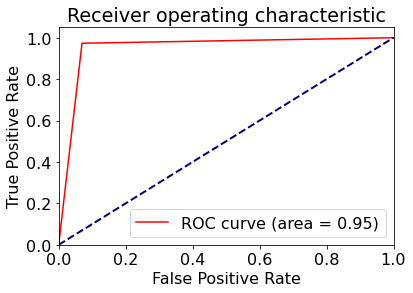

In [45]:
y_2 = LR_model_prob_pred_test_2[:,0] < lr_th_2
model_evaluaiton(y_test, y_2, "")

----

### Logistic Regression : df_train_5 (i.e. IR = 0.4)

In [46]:
X_train_5, y_train_5 = get_train_data(df_train_5)
LR_best_model_5 = lr_model(X_train_5, y_train_5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    8.9s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.6s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     15625
           1       0.20      0.97      0.33       375

    accuracy                           0.91     16000
   macro avg       0.60      0.94      0.64     16000
weighted avg       0.98      0.91      0.94     16000

[[14171  1454]
 [   10   365]]
Accuracy: 0.9085
roc_auc_score: 0.9401386666666667
precision_score: 0.20065970313358988
recall_score: 0.9733333333333334
f1_score: 0.33272561531449407
CM: FP 1454
CM: FN 10
APS Cost =  19540


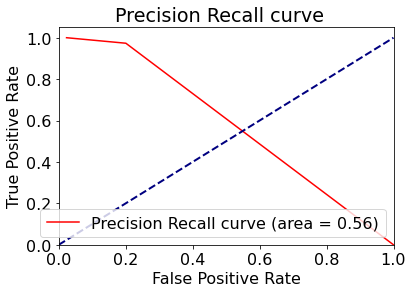

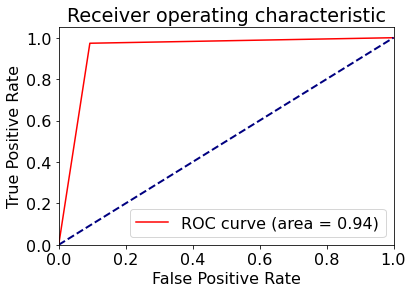

In [47]:
LR_model_pred_test_5, LR_model_prob_pred_test_5 = model_prediction(LR_best_model_5, X_test)
model_evaluaiton(y_test, LR_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94     59000
         1.0       0.44      0.89      0.58      5000

    accuracy                           0.90     64000
   macro avg       0.71      0.90      0.76     64000
weighted avg       0.95      0.90      0.92     64000

[[53255  5745]
 [  562  4438]]
Accuracy: 0.901453125
roc_auc_score: 0.8951135593220338
precision_score: 0.4358244132377492
recall_score: 0.8876
f1_score: 0.5846011987090826
CM: FP 5745
CM: FN 562
APS Cost =  338450


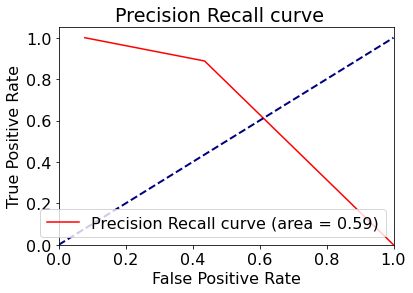

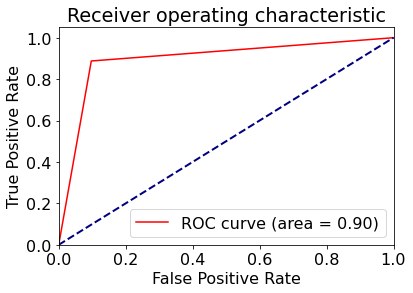

In [48]:
LR_model_pred_train_5, LR_model_prob_pred_train_5 = model_prediction(LR_best_model_5, X_train_5)
model_evaluaiton(y_train_5, LR_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [49]:
LR_best_th_5 = find_cut_off(y_test, LR_model_prob_pred_test_5[:,1])

100%|██████████| 14817/14817 [22:00<00:00, 11.22it/s] 

Best threshold: 0.5376
Min cost: 17940.00


In [50]:
LR_best_th_5

0.5375731317476907

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     15625
           1       0.22      0.97      0.36       375

    accuracy                           0.92     16000
   macro avg       0.61      0.95      0.66     16000
weighted avg       0.98      0.92      0.94     16000

[[14331  1294]
 [   10   365]]
Accuracy: 0.9185
roc_auc_score: 0.9452586666666667
precision_score: 0.22001205545509342
recall_score: 0.9733333333333334
f1_score: 0.3588987217305801
CM: FP 1294
CM: FN 10
APS Cost =  17940


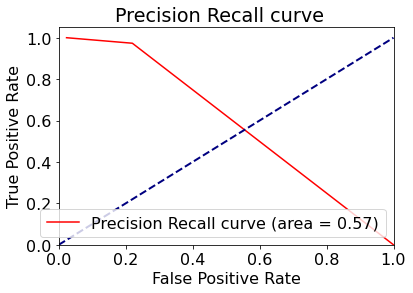

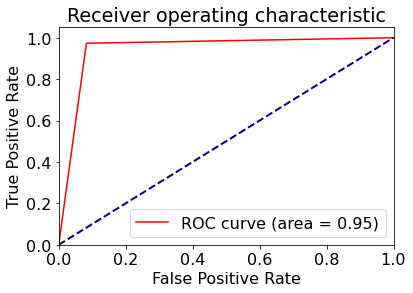

In [51]:
LR_predict_test_th_5 = LR_model_prob_pred_test_5[:,1] > LR_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [52]:
(1.0-LR_best_th_5)
lr_th_5 = round((1.0-LR_best_th_5),3)
lr_th_5

0.4624268682523093

0.462

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     15625
           1       0.22      0.97      0.36       375

    accuracy                           0.92     16000
   macro avg       0.61      0.95      0.66     16000
weighted avg       0.98      0.92      0.94     16000

[[14331  1294]
 [   10   365]]
Accuracy: 0.9185
roc_auc_score: 0.9452586666666667
precision_score: 0.22001205545509342
recall_score: 0.9733333333333334
f1_score: 0.3588987217305801
CM: FP 1294
CM: FN 10
APS Cost =  17940


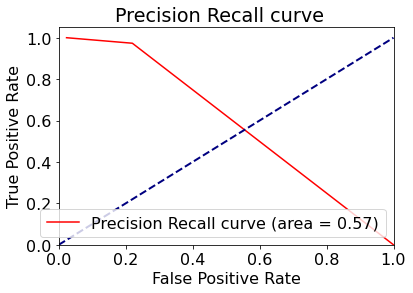

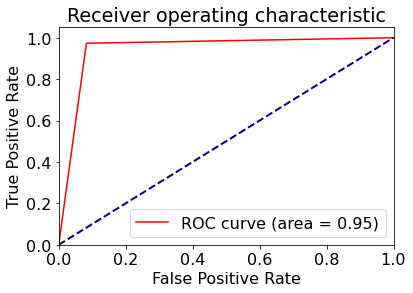

In [53]:
y_5 = LR_model_prob_pred_test_5[:,0] < lr_th_5
model_evaluaiton(y_test, y_5, "")

-----

### Logistic Regression : df_train_10 (i.e. IR = 0.6)

In [54]:
X_train_10, y_train_10 = get_train_data(df_train_10)
LR_best_model_10 = lr_model(X_train_10, y_train_10)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    4.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.7s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     15625
           1       0.19      0.96      0.32       375

    accuracy                           0.90     16000
   macro avg       0.60      0.93      0.63     16000
weighted avg       0.98      0.90      0.93     16000

[[14111  1514]
 [   14   361]]
Accuracy: 0.9045
roc_auc_score: 0.9328853333333333
precision_score: 0.19253333333333333
recall_score: 0.9626666666666667
f1_score: 0.3208888888888889
CM: FP 1514
CM: FN 14
APS Cost =  22140


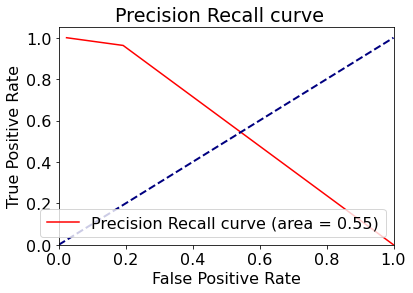

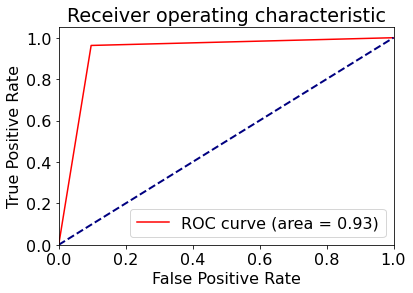

In [55]:
LR_model_pred_test_10, LR_model_prob_pred_test_10 = model_prediction(LR_best_model_10, X_test)
model_evaluaiton(y_test, LR_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94     59000
         1.0       0.61      0.91      0.73     10000

    accuracy                           0.90     69000
   macro avg       0.79      0.90      0.83     69000
weighted avg       0.93      0.90      0.91     69000

[[53116  5884]
 [  928  9072]]
Accuracy: 0.9012753623188405
roc_auc_score: 0.903735593220339
precision_score: 0.6065792992778818
recall_score: 0.9072
f1_score: 0.727039589677833
CM: FP 5884
CM: FN 928
APS Cost =  522840


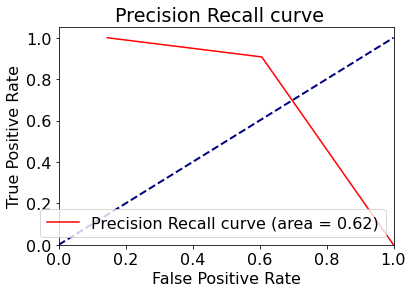

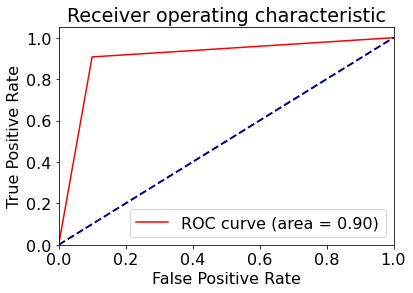

In [56]:
LR_model_pred_train_10, LR_model_prob_pred_train_10 = model_prediction(LR_best_model_10, X_train_10)
model_evaluaiton(y_train_10, LR_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [57]:
LR_best_th_10 = find_cut_off(y_test, LR_model_prob_pred_test_10[:,1])

100%|██████████| 15985/15985 [19:50<00:00, 13.43it/s]  

Best threshold: 0.6687
Min cost: 21520.00


In [58]:
LR_best_th_10

0.6686872683358487

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.26      0.94      0.41       375

    accuracy                           0.94     16000
   macro avg       0.63      0.94      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14623  1002]
 [   23   352]]
Accuracy: 0.9359375
roc_auc_score: 0.9372693333333335
precision_score: 0.25997045790251105
recall_score: 0.9386666666666666
f1_score: 0.40717177559282813
CM: FP 1002
CM: FN 23
APS Cost =  21520


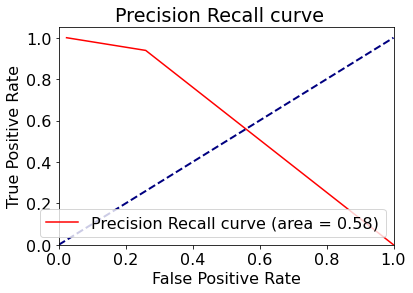

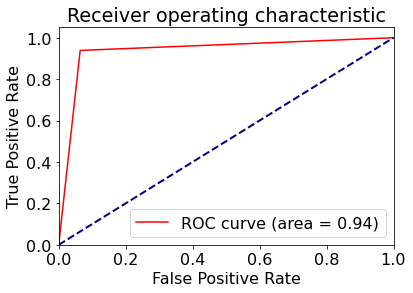

In [59]:
LR_predict_test_th_10 = LR_model_prob_pred_test_10[:,1] > LR_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [60]:
(1.0-LR_best_th_10)
lr_th_3 = round((1.0-LR_best_th_10),3)
lr_th_3

0.3313127316641513

0.331

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.26      0.94      0.41       375

    accuracy                           0.94     16000
   macro avg       0.63      0.94      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14623  1002]
 [   23   352]]
Accuracy: 0.9359375
roc_auc_score: 0.9372693333333335
precision_score: 0.25997045790251105
recall_score: 0.9386666666666666
f1_score: 0.40717177559282813
CM: FP 1002
CM: FN 23
APS Cost =  21520


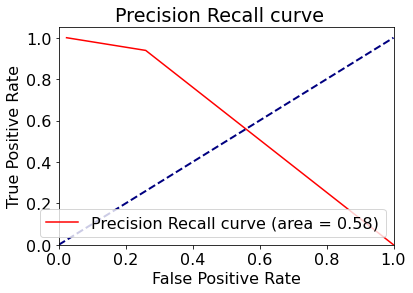

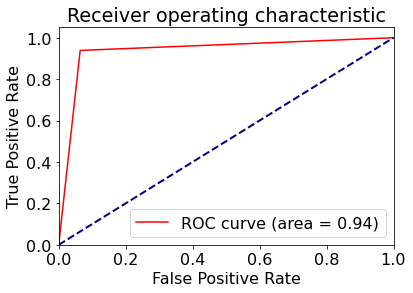

In [61]:
y_10 = LR_model_prob_pred_test_10[:,0] < lr_th_3
model_evaluaiton(y_test, y_10, "")

----

### Random Forest

In [62]:
def RF_model(X_train, y_train):
    RF_hyperparameters = {
                'n_estimators': [50, 100, 250],
                 #'max_features': ['auto', 'sqrt', 'log2'],
                # 'max_depth': [5, 6, 8, None],
                'max_depth': [5, 6, 8],
                'criterion': ['gini', 'entropy']}

    ## Best Params based on running the previous range of hyperparameter
#     RF_hyperparameters = {
#                           'n_estimators': [250],
#                            'max_depth': [5],
#                           'criterion': ['entropy']}
    RF_clf = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state= RANDOM_STATE),
                                   param_grid=RF_hyperparameters, cv=5,
                                   verbose=2, scoring=scoring_fn, n_jobs=-1)

    RF_best_model = RF_clf.fit(X_train, y_train)
    return RF_best_model

### df_train_2 (i.e. IR = 0.2)

In [63]:
X_train_2, y_train_2 = get_train_data(df_train_2)
RF_best_model_2 = RF_model(X_train_2, y_train_2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.4min finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     15625
           1       0.26      0.97      0.41       375

    accuracy                           0.93     16000
   macro avg       0.63      0.95      0.69     16000
weighted avg       0.98      0.93      0.95     16000

[[14582  1043]
 [   11   364]]
Accuracy: 0.934125
roc_auc_score: 0.9519573333333334
precision_score: 0.258

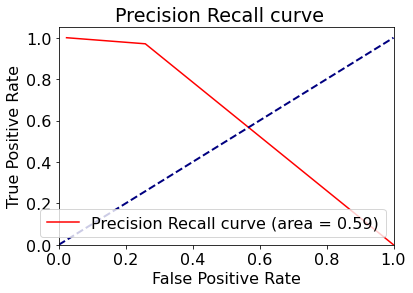

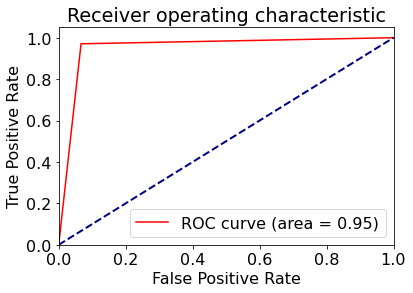

In [64]:
RF_model_pred_test_2, RF_model_prob_pred_test_2 = model_prediction(RF_best_model_2, X_test)
model_evaluaiton(y_test, RF_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     59000
         1.0       0.33      0.98      0.49      2000

    accuracy                           0.93     61000
   macro avg       0.66      0.96      0.73     61000
weighted avg       0.98      0.93      0.95     61000

[[54966  4034]
 [   39  1961]]
Accuracy: 0.9332295081967213
roc_auc_score: 0.9560635593220339
precision_sc

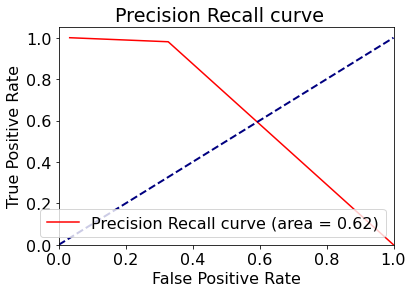

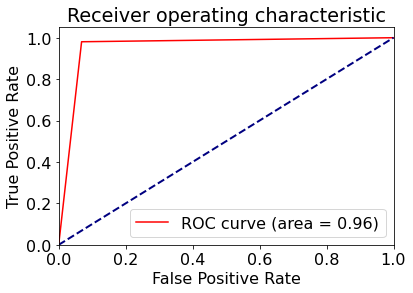

In [65]:
RF_model_pred_train_2, RF_model_prob_pred_train_2 = model_prediction(RF_best_model_2, X_train_2)
model_evaluaiton(y_train_2, RF_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [66]:
RF_best_th_2 = find_cut_off(y_test, RF_model_prob_pred_test_2[:,1])

100%|██████████| 7594/7594 [11:04<00:00, 11.43it/s]

Best threshold: 0.4553
Min cost: 15200.00


In [67]:
RF_best_th_2

0.45530196711698506

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.98      0.39       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14505  1120]
 [    8   367]]
Accuracy: 0.9295
roc_auc_score: 0.9534933333333334
precision_score: 0.24680564895763282
recall_score: 0.9786666666666667
f1_score: 0.3941997851772288
CM: FP 1120
CM: FN 8
APS Cost =  15200


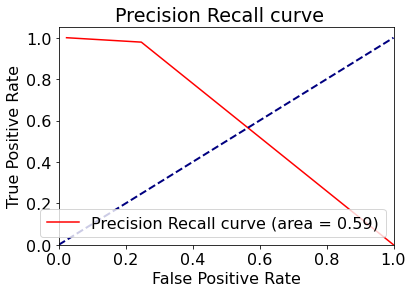

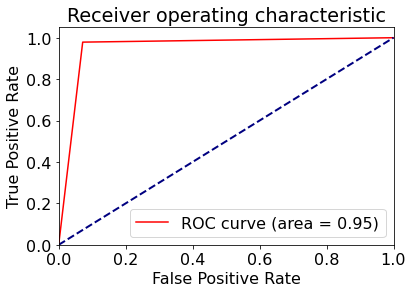

In [68]:
RF_predict_test_th_2 = RF_model_prob_pred_test_2[:,1] > RF_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [69]:
(1.0-RF_best_th_2)
rf_th_2 = round((1.0-RF_best_th_2),3)
rf_th_2

0.5446980328830149

0.545

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.98      0.39       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14502  1123]
 [    8   367]]
Accuracy: 0.9293125
roc_auc_score: 0.9533973333333334
precision_score: 0.24630872483221478
recall_score: 0.9786666666666667
f1_score: 0.3935656836461126
CM: FP 1123
CM: FN 8
APS Cost =  15230


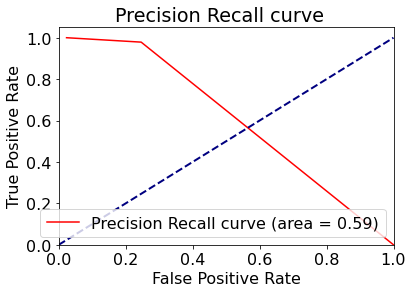

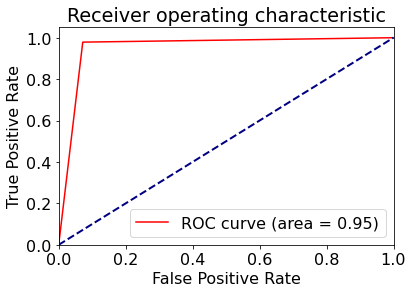

In [70]:
y_2 = RF_model_prob_pred_test_2[:,0] < rf_th_2
model_evaluaiton(y_test, y_2, "")

------

### df_train_5 (i.e. IR = 0.4)

In [71]:
X_train_5, y_train_5 = get_train_data(df_train_5)
RF_best_model_5 = RF_model(X_train_5, y_train_5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.0min finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     15625
           1       0.44      0.88      0.59       375

    accuracy                           0.97     16000
   macro avg       0.72      0.93      0.79     16000
weighted avg       0.98      0.97      0.98     16000

[[15212   413]
 [   44   331]]
Accuracy: 0.9714375
roc_auc_score: 0.9281173333333333
precision_score: 0.4

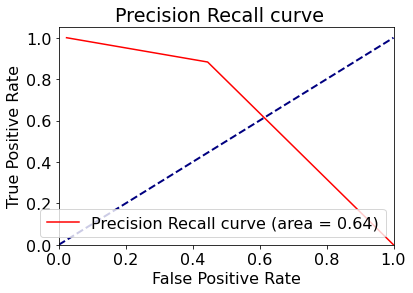

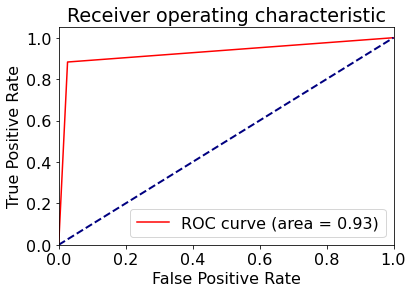

In [72]:
RF_model_pred_test_5, RF_model_prob_pred_test_5 = model_prediction(RF_best_model_5, X_test)
model_evaluaiton(y_test, RF_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     59000
         1.0       0.76      0.99      0.86      5000

    accuracy                           0.97     64000
   macro avg       0.88      0.98      0.92     64000
weighted avg       0.98      0.97      0.98     64000

[[57442  1558]
 [   69  4931]]
Accuracy: 0.974578125
roc_auc_score: 0.9798966101694915
precision_score: 0

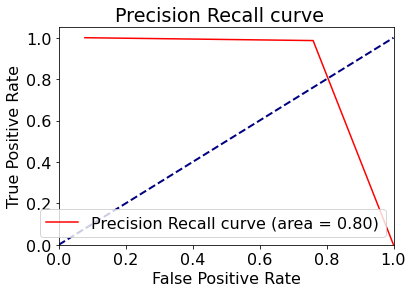

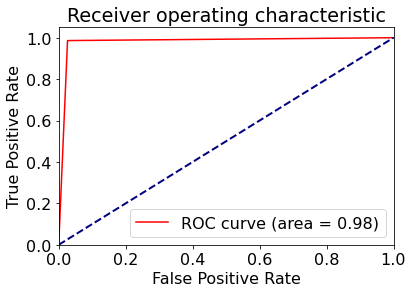

In [73]:
RF_model_pred_train_5, RF_model_prob_pred_train_5 = model_prediction(RF_best_model_5, X_train_5)
model_evaluaiton(y_train_5, RF_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [74]:
RF_best_th_5 = find_cut_off(y_test, RF_model_prob_pred_test_5[:,1])

100%|██████████| 9036/9036 [10:54<00:00, 13.80it/s]

Best threshold: 0.1847
Min cost: 12910.00


In [75]:
RF_best_th_5

0.1846788103741209

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.98      0.45       375

    accuracy                           0.94     16000
   macro avg       0.65      0.96      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14734   891]
 [    8   367]]
Accuracy: 0.9438125
roc_auc_score: 0.9608213333333334
precision_score: 0.2917329093799682
recall_score: 0.9786666666666667
f1_score: 0.449479485609308
CM: FP 891
CM: FN 8
APS Cost =  12910


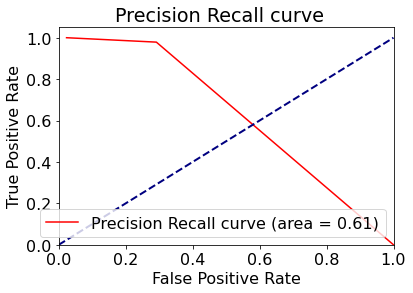

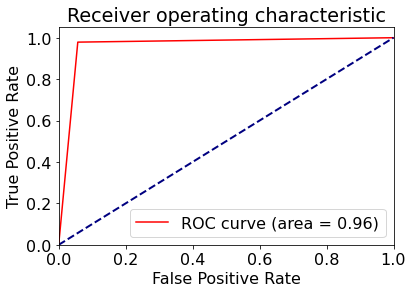

In [76]:
RF_predict_test_th_5 = RF_model_prob_pred_test_5[:,1] > RF_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [77]:
(1.0-RF_best_th_5)
rf_th_5 = round((1.0-RF_best_th_5),3)
rf_th_5

0.8153211896258791

0.815

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.98      0.45       375

    accuracy                           0.94     16000
   macro avg       0.65      0.96      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14734   891]
 [    8   367]]
Accuracy: 0.9438125
roc_auc_score: 0.9608213333333334
precision_score: 0.2917329093799682
recall_score: 0.9786666666666667
f1_score: 0.449479485609308
CM: FP 891
CM: FN 8
APS Cost =  12910


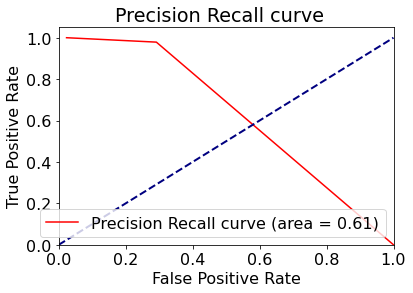

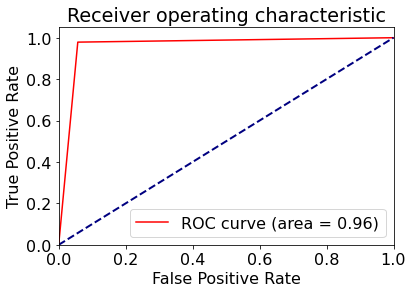

In [78]:
y_5 = RF_model_prob_pred_test_5[:,0] < rf_th_5
model_evaluaiton(y_test, y_5, "")

-----

### df_train_10 (i.e. IR = 0.6)

In [79]:
X_train_10, y_train_10 = get_train_data(df_train_10)
RF_best_model_10 = RF_model(X_train_10, y_train_10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.6min finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.49      0.80      0.61       375

    accuracy                           0.98     16000
   macro avg       0.74      0.89      0.80     16000
weighted avg       0.98      0.98      0.98     16000

[[15314   311]
 [   75   300]]
Accuracy: 0.975875
roc_auc_score: 0.890048
precision_score: 0.4909983633387

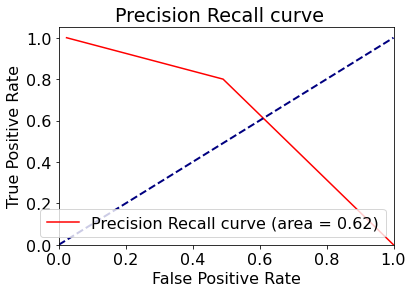

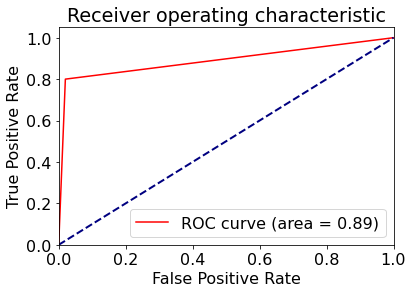

In [80]:
RF_model_pred_test_10, RF_model_prob_pred_test_10 = model_prediction(RF_best_model_10, X_test)
model_evaluaiton(y_test, RF_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     59000
         1.0       0.90      0.99      0.94     10000

    accuracy                           0.98     69000
   macro avg       0.95      0.98      0.96     69000
weighted avg       0.98      0.98      0.98     69000

[[57846  1154]
 [  123  9877]]
Accuracy: 0.9814927536231884
roc_auc_score: 0.9840703389830509
precision_sc

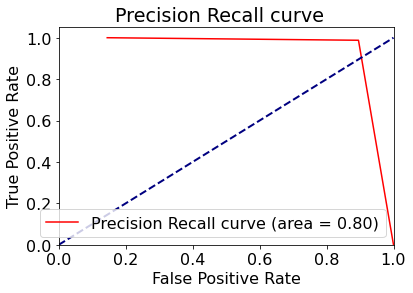

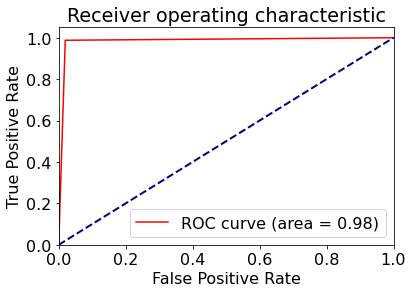

In [81]:
RF_model_pred_train_10, RF_model_prob_pred_train_10 = model_prediction(RF_best_model_10, X_train_10)
model_evaluaiton(y_train_10, RF_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [82]:
RF_best_th_10 = find_cut_off(y_test, RF_model_prob_pred_test_10[:,1])

100%|██████████| 5962/5962 [08:14<00:00, 12.06it/s]

Best threshold: 0.0954
Min cost: 13330.00


In [83]:
RF_best_th_10

0.09537221107165177

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.99      0.40       375

    accuracy                           0.93     16000
   macro avg       0.63      0.96      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14542  1083]
 [    5   370]]
Accuracy: 0.932
roc_auc_score: 0.9586773333333334
precision_score: 0.25464556090846524
recall_score: 0.9866666666666667
f1_score: 0.4048140043763676
CM: FP 1083
CM: FN 5
APS Cost =  13330


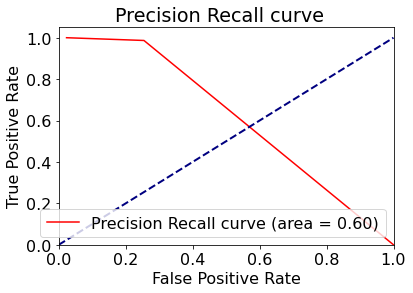

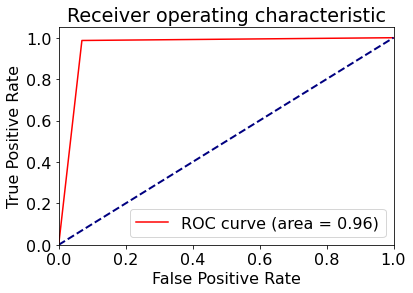

In [84]:
RF_predict_test_th_10 = RF_model_prob_pred_test_10[:,1] > RF_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [85]:
(1.0-RF_best_th_10)
rf_th_10 = round((1.0-RF_best_th_10),3)
rf_th_10

0.9046277889283483

0.905

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.99      0.40       375

    accuracy                           0.93     16000
   macro avg       0.63      0.96      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14541  1084]
 [    5   370]]
Accuracy: 0.9319375
roc_auc_score: 0.9586453333333335
precision_score: 0.2544704264099037
recall_score: 0.9866666666666667
f1_score: 0.4045926735921268
CM: FP 1084
CM: FN 5
APS Cost =  13340


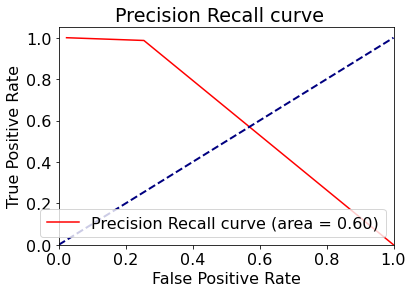

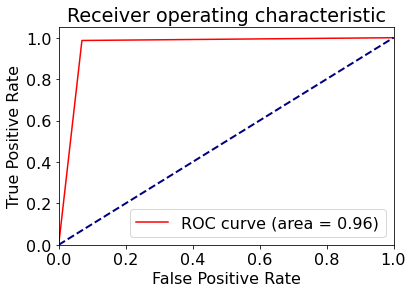

In [86]:
y_10 = RF_model_prob_pred_test_10[:,0] < rf_th_10
model_evaluaiton(y_test, y_10, "")

---

## XGBoost

In [87]:
def xgb_model(X_train, y_train):
    xg_hyperparameters = {
                    'max_depth': [3, 4, 5],
                    'n_estimators': [50, 100],
                    'learning_rate': [0.1, 0.01, 0.05, 0.03]
                }

    # best param when PCA is used
#     xg_hyperparameters = {
#                     'max_depth': [5],
#                     'n_estimators': [100],
#                     'learning_rate': [0.1]
#                 }
    xg_clf = GridSearchCV(estimator=xgb.XGBClassifier(random_state=RANDOM_STATE),
                                   param_grid=xg_hyperparameters, cv=5,
                                   scoring=scoring_fn, n_jobs=-1,verbose=2)
    
    xgbb_best_model = xg_clf.fit(X_train, y_train)
    return xgbb_best_model

### df_train_2 (i.e. IR = 0.2)

In [88]:
X_train_2, y_train_2 = get_train_data(df_train_2)
xgb_best_model_2 = xgb_model(X_train_2, y_train_2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.9min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.75      0.38      0.51       375

    accuracy                           0.98     16000
   macro avg       0.87      0.69      0.75     16000
weighted avg       0.98      0.98      0.98     16000

[[15577    48]
 [  231   144]]
Accuracy

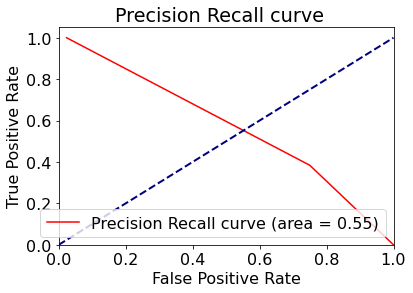

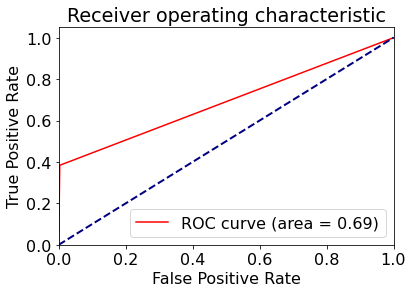

In [89]:
xgb_model_pred_test_2, xgb_model_prob_pred_test_2 = model_prediction(xgb_best_model_2, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     59000
         1.0       0.95      0.77      0.85      2000

    accuracy                           0.99     61000
   macro avg       0.97      0.88      0.92     61000
weighted avg       0.99      0.99      0.99     61000

[[58918    82]
 [  470  1530]]
Accuracy

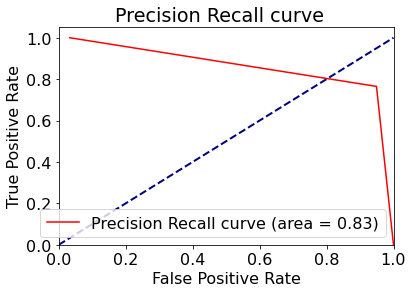

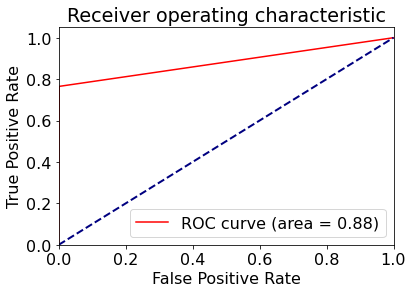

In [90]:
xgb_model_pred_train_2, xgb_model_prob_pred_train_2 = model_prediction(xgb_best_model_2, X_train_2)
model_evaluaiton(y_train_2, xgb_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [91]:
xgb_best_th_2 = find_cut_off(y_test, xgb_model_prob_pred_test_2[:,1])

100%|██████████| 7314/7314 [08:24<00:00, 14.51it/s]

Best threshold: 0.0194
Min cost: 13190.00


In [92]:
xgb_best_th_2

0.01941835

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.98      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14706   919]
 [    8   367]]
Accuracy: 0.9420625
roc_auc_score: 0.9599253333333334
precision_score: 0.2853810264385692
recall_score: 0.9786666666666667
f1_score: 0.4419024683925346
CM: FP 919
CM: FN 8
APS Cost =  13190


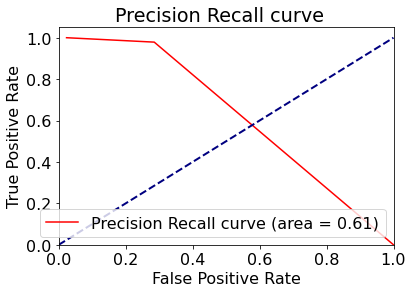

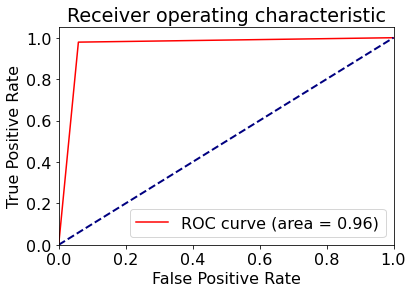

In [93]:
xgb_predict_test_th_2 = xgb_model_prob_pred_test_2[:,1] > xgb_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [94]:
(1.0-xgb_best_th_2)
xg_th_2 = round((1.0-xgb_best_th_2),3)
xg_th_2

0.9805816505104303

0.981

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.28      0.98      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.96     16000

[[14699   926]
 [    8   367]]
Accuracy: 0.941625
roc_auc_score: 0.9597013333333334
precision_score: 0.2838360402165507
recall_score: 0.9786666666666667
f1_score: 0.4400479616306955
CM: FP 926
CM: FN 8
APS Cost =  13260


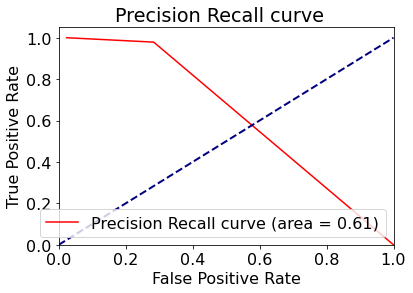

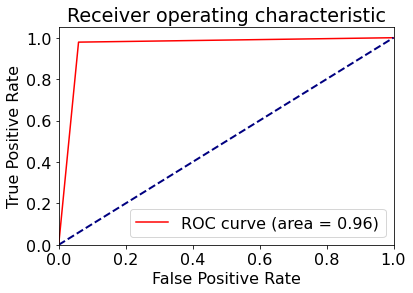

In [95]:
y_2 = xgb_model_prob_pred_test_2[:,0] < xg_th_2
model_evaluaiton(y_test, y_2, "")

-----

### df_train_5 (i.e. IR = 0.4)

In [96]:
X_train_5, y_train_5 = get_train_data(df_train_5)
xgb_best_model_5 = xgb_model(X_train_5, y_train_5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.3min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.72      0.37      0.49       375

    accuracy                           0.98     16000
   macro avg       0.85      0.68      0.74     16000
weighted avg       0.98      0.98      0.98     16000

[[15572    53]
 [  237   138]]
Accuracy

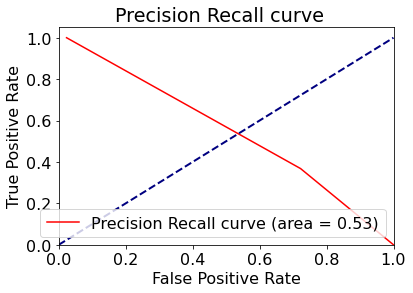

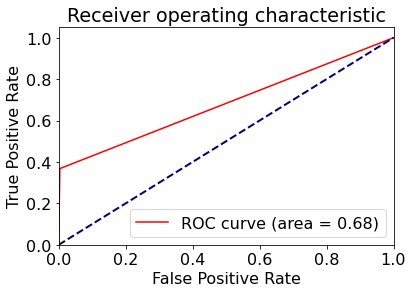

In [97]:
xgb_model_pred_test_5, xgb_model_prob_pred_test_5 = model_prediction(xgb_best_model_5, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     59000
         1.0       0.98      0.90      0.94      5000

    accuracy                           0.99     64000
   macro avg       0.98      0.95      0.97     64000
weighted avg       0.99      0.99      0.99     64000

[[58897   103]
 [  503  4497]]
Accuracy

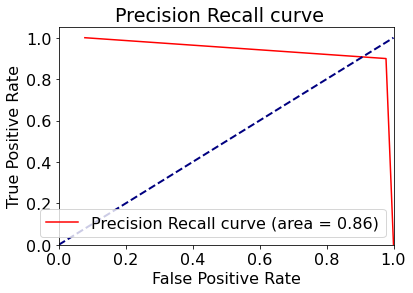

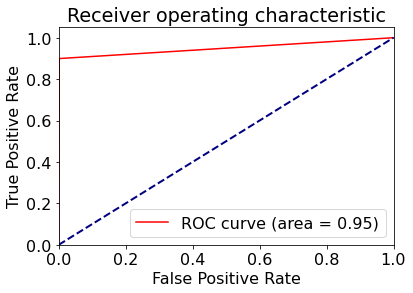

In [98]:
xgb_model_pred_train_5, xgb_model_prob_pred_train_5 = model_prediction(xgb_best_model_5, X_train_5)
model_evaluaiton(y_train_5, xgb_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [99]:
xgb_best_th_5 = find_cut_off(y_test, xgb_model_prob_pred_test_5[:,1])

100%|██████████| 7308/7308 [06:21<00:00, 19.15it/s]

Best threshold: 0.0119
Min cost: 13280.00


In [100]:
xgb_best_th_5

0.011863412

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.26      0.99      0.41       375

    accuracy                           0.93     16000
   macro avg       0.63      0.96      0.69     16000
weighted avg       0.98      0.93      0.95     16000

[[14547  1078]
 [    5   370]]
Accuracy: 0.9323125
roc_auc_score: 0.9588373333333335
precision_score: 0.255524861878453
recall_score: 0.9866666666666667
f1_score: 0.405924300603401
CM: FP 1078
CM: FN 5
APS Cost =  13280


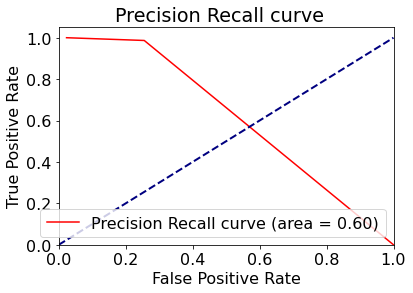

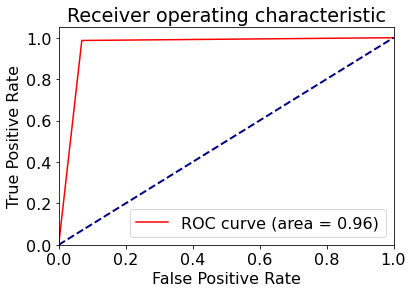

In [101]:
xgb_predict_test_th_5 = xgb_model_prob_pred_test_5[:,1] > xgb_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [102]:
(1.0-xgb_best_th_5)
xg_th_5 = round((1.0-xgb_best_th_5),3)
xg_th_5

0.988136587664485

0.988

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.26      0.98      0.41       375

    accuracy                           0.93     16000
   macro avg       0.63      0.96      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14550  1075]
 [    6   369]]
Accuracy: 0.9324375
roc_auc_score: 0.9576
precision_score: 0.25554016620498615
recall_score: 0.984
f1_score: 0.40571742715777903
CM: FP 1075
CM: FN 6
APS Cost =  13750


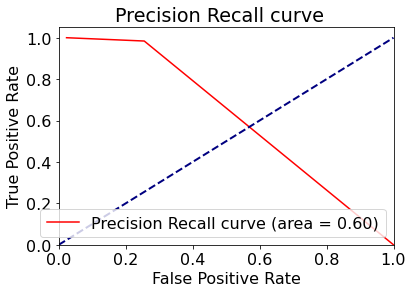

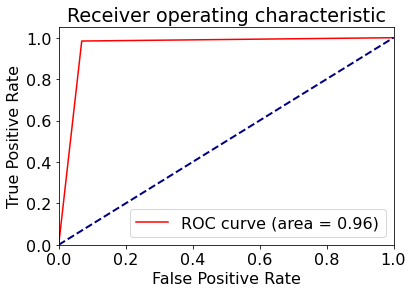

In [103]:
y_5 = xgb_model_prob_pred_test_5[:,0] < xg_th_5
model_evaluaiton(y_test, y_5, "")

----

### df_train_10 (i.e. IR = 0.6)

In [104]:
X_train_10, y_train_10 = get_train_data(df_train_10)
xgb_best_model_10 = xgb_model(X_train_10, y_train_10)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.1min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.72      0.37      0.49       375

    accuracy                           0.98     16000
   macro avg       0.85      0.68      0.74     16000
weighted avg       0.98      0.98      0.98     16000

[[15570    55]
 [  235   140]]
Accuracy

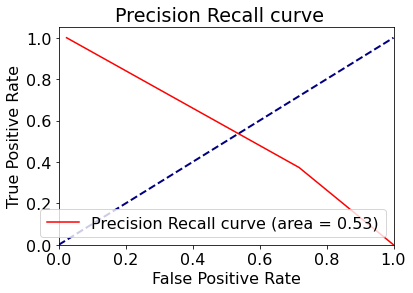

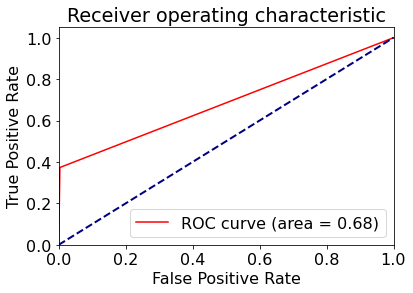

In [105]:
xgb_model_pred_test_10, xgb_model_prob_pred_test_10 = model_prediction(xgb_best_model_10, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     59000
         1.0       0.99      0.95      0.97     10000

    accuracy                           0.99     69000
   macro avg       0.99      0.97      0.98     69000
weighted avg       0.99      0.99      0.99     69000

[[58900   100]
 [  514  9486]]
Accuracy

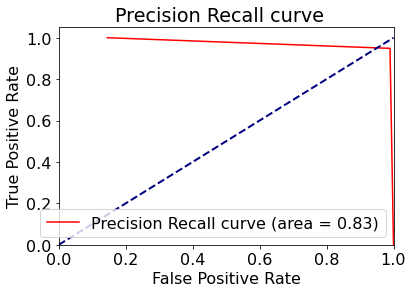

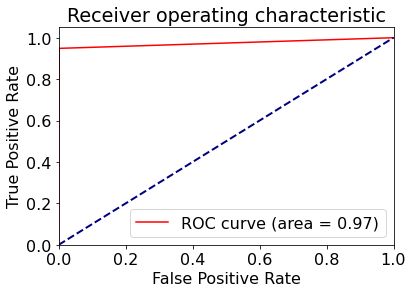

In [106]:
xgb_model_pred_train_10, xgb_model_prob_pred_train_10 = model_prediction(xgb_best_model_10, X_train_10)
model_evaluaiton(y_train_10, xgb_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [107]:
xgb_best_th_10 = find_cut_off(y_test, xgb_model_prob_pred_test_10[:,1])

100%|██████████| 7464/7464 [07:05<00:00, 17.55it/s]

Best threshold: 0.0113
Min cost: 13510.00


In [108]:
xgb_best_th_10

0.0113368295

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.99      0.40       375

    accuracy                           0.93     16000
   macro avg       0.63      0.96      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14524  1101]
 [    5   370]]
Accuracy: 0.930875
roc_auc_score: 0.9581013333333335
precision_score: 0.2515295717199184
recall_score: 0.9866666666666667
f1_score: 0.4008667388949079
CM: FP 1101
CM: FN 5
APS Cost =  13510


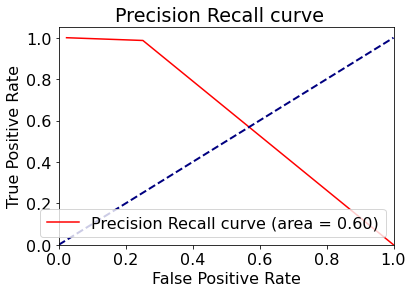

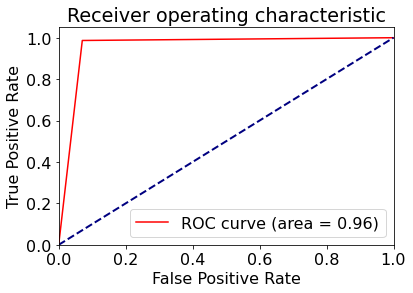

In [109]:
xgb_predict_test_th_10 = xgb_model_prob_pred_test_10[:,1] > xgb_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [110]:
(1.0-xgb_best_th_10)
xg_th_10 = round((1.0-xgb_best_th_10),3)
xg_th_10

0.9886631704866886

0.989

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.99      0.40       375

    accuracy                           0.93     16000
   macro avg       0.62      0.96      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14513  1112]
 [    5   370]]
Accuracy: 0.9301875
roc_auc_score: 0.9577493333333333
precision_score: 0.2496626180836707
recall_score: 0.9866666666666667
f1_score: 0.3984921917070544
CM: FP 1112
CM: FN 5
APS Cost =  13620


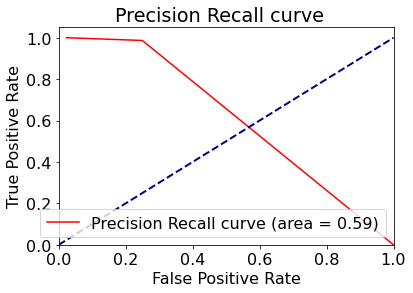

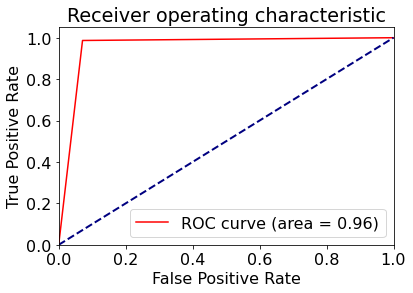

In [111]:
y_10 = xgb_model_prob_pred_test_10[:,0] < xg_th_10
model_evaluaiton(y_test, y_10, "")

-----